Tutorials from

* [Qiskit Chapter 4.2: ](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#backgroundmath)

* [Qiskit Tutorials: Git](https://github.com/Qiskit/qiskit-tutorials)

In [15]:
import numpy as np
np.random.seed(999999)
target_distr = np.random.rand(2)
# We now convert the random vector into a valid probability vector
target_distr /= sum(target_distr)

print (target_distr)

[0.51357006 0.48642994]


In [16]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

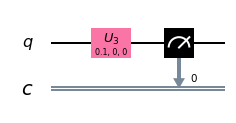

In [17]:
params = [0.1, 0, 0]
qcc = get_var_form(params)
qcc.draw('mpl')

In [18]:
from qiskit import Aer, execute
backend = Aer.get_backend("qasm_simulator")
num_shots = 10000

def get_probability_distribution(counts):
    output_distr = [v / num_shots for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    return output_distr

def objective_function(params):
    # Obtain a quantum circuit instance from the paramters
    qc = get_var_form(params)
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=num_shots).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.abs(output_distr[i] - target_distr[i]) for i in range(2)])
    return cost

In [19]:
from qiskit.aqua.components.optimizers import COBYLA

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=50, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
params = np.random.rand(3)
ret = optimizer.optimize(num_vars=3, objective_function=objective_function, initial_point=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(ret[0])
counts = execute(qc, backend, shots=num_shots).result().get_counts(qc)
output_distr = get_probability_distribution(counts)

print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Output Error (Manhattan Distance):", ret[1])
print("Parameters Found:", ret[0])

Target Distribution: [0.51357006 0.48642994]
Obtained Distribution: [0.5097, 0.4903]
Output Error (Manhattan Distance): 0.017259881261160848
Parameters Found: [ 1.54382599 -0.05532806  0.49874278]


## Structure of Common Variational Forms

=============Linear Entanglement:=============


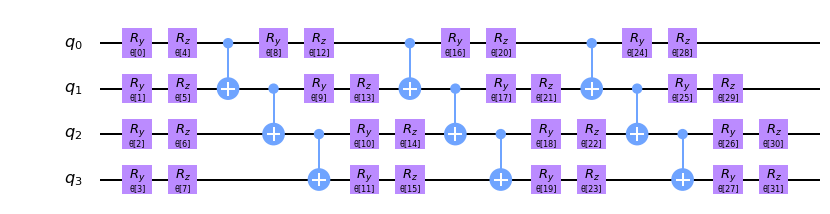


=============Full Entanglement:=============


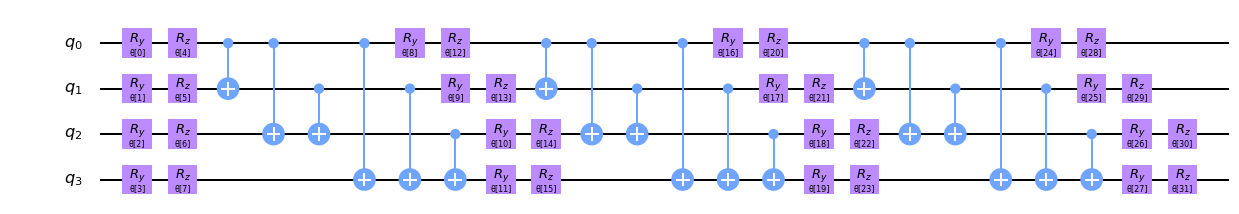

In [10]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    if entanglement == "linear":
        print("=============Linear Entanglement:=============")
    else:
        print("=============Full Entanglement:=============")
    # We initialize all parameters to 0 for this demonstration
    display(form.draw("mpl", fold=100))
    print()

## Running VQE on a Statevector Simulator 

In [11]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel

In [20]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [21]:
dist = 1.

qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)

In [14]:
print ( qubitOp, num_particles, num_spin_orbitals, shift )

Representation: paulis, qubits: 4, size: 100 2 6 -6.6097847711303315


In [22]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/

/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/

/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/usr/local/lib/python3.8/site-packages/qiskit/aqua/operators/state_fns/vector_state_fn.py:156: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  return round(np.dot(self.to_matrix(), front.to_matrix())[0],
/

Interatomic Distance: 0.5 VQE Result: -7.039710211293756 Exact Energy: [-7.03973252]


QiskitError: 'Keyboard interrupt in parallel_map.'

In [ ]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()